<a href="https://colab.research.google.com/github/scottpauls/genai-teaching-tools/blob/main/embedding_dartLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

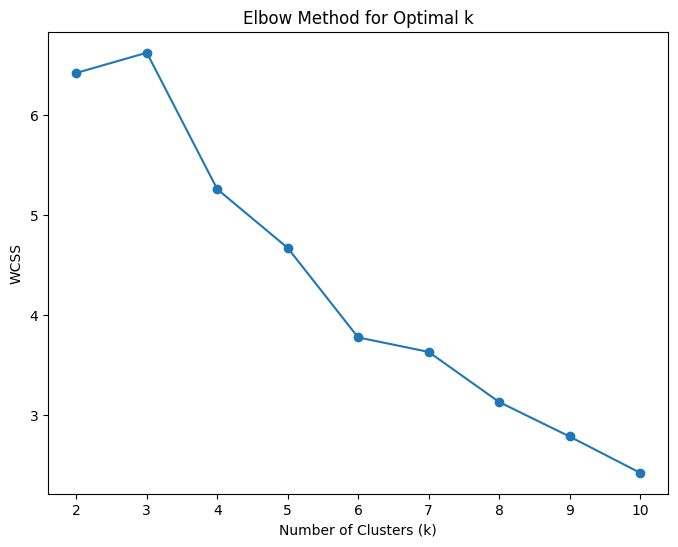

IntSlider(value=2, description='k:', max=10, min=2)

Output()

Dropdown(description='Select Cluster:', options=(2, 0, 1), value=2)

In [ ]:
import pandas as pd
import numpy as np
!pip install --upgrade langchain_dartmouth openai
from langchain_dartmouth.embeddings import DartmouthEmbeddings
from langchain_dartmouth.llms import ChatDartmouth
from sklearn.metrics.pairwise import cosine_distances
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
import csv

from google.colab import userdata
os.environ["DARTMOUTH_API_KEY"] = userdata.get('DARTMOUTH_API_KEY')
llm = ChatDartmouth(model_name="codellama-13b-hf")  # Initialize local LLM

def summarize_phrases(phrases):
      # Limit the number of phrases sent to the LLM
      max_phrases = 5  # Adjust as needed
      selected_phrases = phrases[:max_phrases]

      txt1 = "<s>[INST] The following are a list of phrases that are part of a cluster.  Please generate a theme that summarizes them. " + " ".join(selected_phrases)
      txt2 = txt1 + " [/INST]"
      summary = llm.invoke(txt2)
      return summary



# Function to obtain embeddings
def get_embedding(text):
    Dembeddings = DartmouthEmbeddings()
    text = str(text)
    response = Dembeddings.embed_query(text)
    return response

# Function to perform clustering and visualization
def cluster_and_visualize(df, k_range):
    phrases = df['phrase'].tolist()
    embeddings = [get_embedding(phrase) for phrase in phrases]
    embeddings_array = np.array(embeddings)
    distance_matrix = cosine_distances(embeddings_array)


    np.savetxt('embeddings_array.csv', embeddings_array, delimiter=',', fmt='%f')  # Adjust delimiter and format as needed
    np.savetxt('distance_array.csv', distance_matrix, delimiter=',', fmt='%f')  # Adjust delimiter and format as needed



    # Elbow method for optimal k
    wcss = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings_array)
        wcss.append(kmeans.inertia_)

    plt.figure(figsize=(8, 6))
    plt.plot(k_range, wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

    # Create an output widget to display the visualization
    output_widget = widgets.Output()


    # Get user input for k
    k_input = widgets.IntSlider(min=k_range[0], max=k_range[-1], step=1, description='k:')
    # Define cluster selection dropdown outside update_visualization
    cluster_dropdown = widgets.Dropdown(options=[], description='Select Cluster:')

     # Define the visualization update function
    def update_visualization(change):
        k = change['new']  # Get the new value of k

        # Perform clustering and visualization with selected k
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(embeddings_array)
        labels = kmeans.labels_
        np.savetxt('cluster_labels.csv', labels , delimiter=';', fmt='%g')

        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        mds_coords = mds.fit_transform(distance_matrix)

        mds_df = pd.DataFrame(mds_coords, columns=['X', 'Y'])
        mds_df['phrase'] = phrases
        mds_df['cluster'] = labels

        # Clear previous output and display the new plot
        with output_widget:
            clear_output(wait=True)
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(mds_df['X'], mds_df['Y'], c=mds_df['cluster'], cmap='viridis', alpha=0.7)
            plt.legend(*scatter.legend_elements(), title="Clusters")
            plt.title(f'k-Means Clustering Visualization (k={k})')
            plt.xlabel('MDS Dimension 1')
            plt.ylabel('MDS Dimension 2')
            plt.grid(True)
            plt.show()
        # Add cluster selection dropdown
        cluster_dropdown = widgets.Dropdown(options=list(mds_df['cluster'].unique()), description='Select Cluster:')
        display(cluster_dropdown)

    # Define function to display phrases and summary
    def display_cluster_phrases(change):
      selected_cluster = change['new']
      cluster_phrases = mds_df[mds_df['cluster'] == selected_cluster]['phrase'].tolist()
      print("Phrases in cluster", selected_cluster, ":")
      for phrase in cluster_phrases:
        print(phrase)

      # Generate and display LLM summary
      summary = summarize_phrases(cluster_phrases)  # Call LLM summarization function
      print("\n\nLLM Summary: \n")
      print(summary)

    # Observe cluster dropdown for changes
    cluster_dropdown.observe(display_cluster_phrases, names='value')
    # Observe the slider for changes
    k_input.observe(update_visualization, names='value')

    # Display the slider and the output
    display(k_input, output_widget)

# File upload widget
uploader = widgets.FileUpload(accept='.csv', description='Upload CSV')
display(uploader)

# Button to trigger clustering
button = widgets.Button(description='Cluster')
display(button)

# Event handler for button click
def on_button_click(b):
    clear_output()
    uploaded_file = uploader.data[0]
    df = pd.read_csv(io.BytesIO(uploaded_file)) # Use io.BytesIO to read the CSV data
    cluster_and_visualize(df, range(2, 11)) # Example k range

button.on_click(on_button_click)

